In [ ]:
# Code by Irfan Bin Islam and Dr. Ghazanfar Latif / CAI@PMU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
print("All needed packages imported successfully!")

All needed packages imported successfully!


In [2]:

data_dir = r'C:\Samples\Long'

# You have to change based on the your dataset folder names.
classes=['Silk', 'Cotton', 'Polyester']

In [3]:
import os
from glob import glob
images = glob(os.path.join(data_dir, '*/*.png'))
tot_images = len(images)
print('Total images:', tot_images)

# import cv2
# img1 = cv2.resize(img1, (224, 224))

Total images: 0


In [4]:
im_cnt = []
class_names = []
print('{:18s}'.format('Class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < tot_images):
        tot_images = folder_num
        folder_num = folder

num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))



Class             Count
------------------------
Cotton               275
Polyester            272
Silk                 300
Total number of classes: 3


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np

# Define transformations
data_transforms = {
    "train_transforms": transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "valid_test_transforms": transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=None)

# Retrieve targets (labels) for stratification
targets = full_dataset.targets

# Split dataset into train, validation, and test sets using stratified sampling
train_idx, temp_idx = train_test_split(list(range(len(full_dataset))), stratify=targets, test_size=0.2)
valid_idx, test_idx = train_test_split(temp_idx, stratify=[targets[i] for i in temp_idx], test_size=0.5)

# Create subsets for train, validation, and test using the indices from the splits
train_data = torch.utils.data.Subset(full_dataset, train_idx)
valid_data = torch.utils.data.Subset(full_dataset, valid_idx)
test_data = torch.utils.data.Subset(full_dataset, test_idx)

# Apply transformations to each subset
train_data.dataset.transform = data_transforms["train_transforms"]
valid_data.dataset.transform = data_transforms["valid_test_transforms"]
test_data.dataset.transform = data_transforms["valid_test_transforms"]

# Create DataLoaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
validloader = DataLoader(valid_data, batch_size=16, shuffle=False)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

# Verify the sizes and ensure iteration works
print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

Total samples: 847
Training samples: 677
Validation samples: 85
Test samples: 85


In [6]:
# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [7]:
# Create DataLoaders with the appropriate transformations and samplers 
trainloader = DataLoader(datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"]), batch_size=16, sampler=train_sampler) 
validloader = DataLoader(datasets.ImageFolder(data_dir, transform=data_transforms["valid_test_transforms"]), batch_size=16, sampler=valid_sampler) 
testloader = DataLoader(datasets.ImageFolder(data_dir, transform=data_transforms["valid_test_transforms"]), batch_size=16, sampler=test_sampler)

In [8]:
#helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image type to numpy image type for visualization

In [9]:
# Specify model architecture
# Load the pretrained model from pytorch's library and stored it in model_transfer
#model_transfer = models.googlenet(pretrained=True)
#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.alexnet(pretrained=True)
# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

C:\Users\patwe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\patwe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#print the model to see all the layers
print(model_transfer)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
#Lets read the fully connected layer
print("Original input features:", model_transfer.classifier[6].in_features)
print("Original output features:", model_transfer.classifier[6].out_features)

Original input features: 4096
Original output features: 1000


In [12]:
for param in model_transfer.parameters():
    param.requires_grad=True

In [13]:
# Define n_inputs takes the same number of inputs from pre-trained model
n_inputs = model_transfer.classifier[6].in_features #refer to the fully connected layer only

# Add last linear layer (n_inputs -> 4 classes). In this case the ouput is 4 classes
# New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier[6] = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

# Check to see the last layer produces the expected number of outputs
print("New output features:", model_transfer.classifier[6].out_features)  # Should be 4 (the number of classes)

New output features: 3


In [14]:
# Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [15]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf

    for epoch in range(1, n_epochs+1):
        # In the training loop, I track down the loss
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # 1st step: Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()

            # Then, clear (zero out) the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Perform the Cross Entropy Loss. Calculate the batch loss.
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))

        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))

        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
          valid_loss_min,
          valid_loss))
    # Save the model to the specified path
    torch.save(model.state_dict(), r'C:\Coding\alex.pt')  # Use raw string for Windows path
    valid_loss_min = valid_loss

    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'alex.pt')

Epoch: 1 	Training Loss: 0.78548 	Validation Loss: 0.20819
Validation loss decreased (inf --> 0.20819). Saving model ...
Epoch: 2 	Training Loss: 0.39759 	Validation Loss: 0.19678
Validation loss decreased (inf --> 0.19678). Saving model ...
Epoch: 3 	Training Loss: 0.34755 	Validation Loss: 0.05062
Validation loss decreased (inf --> 0.05062). Saving model ...
Epoch: 4 	Training Loss: 0.28027 	Validation Loss: 0.03031
Validation loss decreased (inf --> 0.03031). Saving model ...
Epoch: 5 	Training Loss: 0.28230 	Validation Loss: 0.00377
Validation loss decreased (inf --> 0.00377). Saving model ...
Epoch: 6 	Training Loss: 0.24021 	Validation Loss: 0.27664
Validation loss decreased (inf --> 0.27664). Saving model ...
Epoch: 7 	Training Loss: 0.22852 	Validation Loss: 0.01983
Validation loss decreased (inf --> 0.01983). Saving model ...
Epoch: 8 	Training Loss: 0.22314 	Validation Loss: 0.00998
Validation loss decreased (inf --> 0.00998). Saving model ...
Epoch: 9 	Training Loss: 0.22676

In [16]:
model_transfer.load_state_dict(torch.load(r'C:\Coding\alex.pt'))


C:\Users\patwe\AppData\Local\Temp\ipykernel_10852\349077448.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transfer.load_state_dict(torch.load(r'C:\Coding\alex.pt

<All keys matched successfully>

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval() #set model into evaluation/testing mode. It turns of drop off layer
    #Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.019805


Test Accuracy: 98% (84/85)


Test Loss: 0.021554
Test Accuracy: 98.82% (84/85)
Predicted class counts: {'Cotton': 27, 'Polyester': 28, 'Silk': 30}

Confusion Matrix:
 [[27  1  0]
 [ 0 27  0]
 [ 0  0 30]]


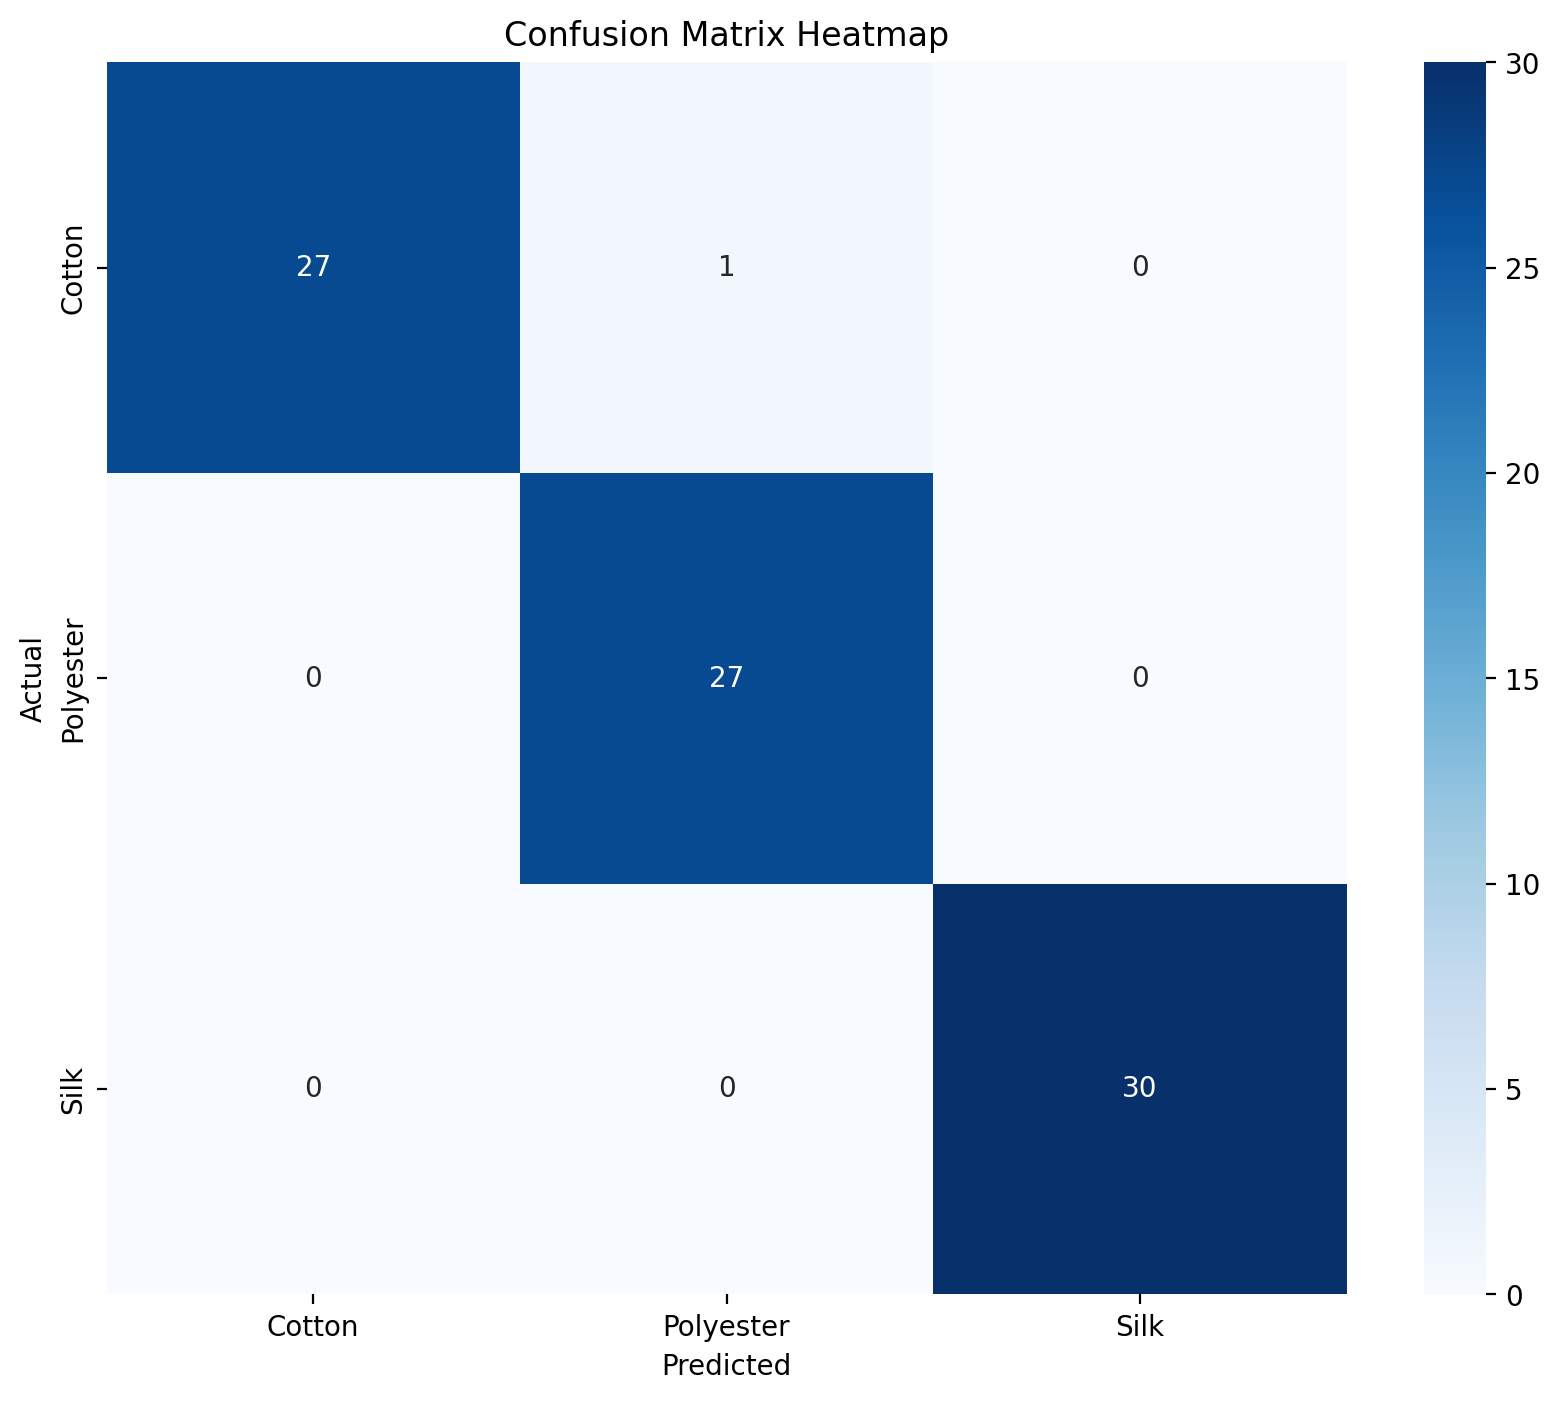


Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.96      0.98        28
   Polyester       0.96      1.00      0.98        27
        Silk       1.00      1.00      1.00        30

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test(loaders, model, criterion, use_cuda, class_names):
    # Initialize variables to monitor test loss and accuracy
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []  # To store all predictions
    all_targets = []  # To store all true labels

    model.eval()  # Set model to evaluation mode (disable dropout, batchnorm updates)
    
    # Iterate over test data
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # Move data and target to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # Directly get the logits; no auxiliary outputs

            # Calculate the loss
            loss = criterion(output, target)

            # Update the cumulative test loss
            test_loss += loss.item()  # Sum the losses for averaging later

            # Get the predicted class by finding the index of the max logit
            pred = output.argmax(1, keepdim=False)  # Index of the max logit

            # Store predictions and true labels
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # Compare predictions to true labels
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    # Calculate average test loss
    test_loss /= len(loaders['test'])  # Average test loss over all batches

    # Print test loss and accuracy
    print(f'Test Loss: {test_loss:.6f}')
    print(f'Test Accuracy: {100. * correct / total:.2f}% ({correct}/{total})')

    # Print class counts in predictions (debugging missing classes)
    print("Predicted class counts:", {class_name: all_preds.count(i) for i, class_name in enumerate(class_names)})

    # Ensure all classes are included in confusion matrix and report
    labels = range(len(class_names))  # Ensure all class indices are included
    cm = confusion_matrix(all_targets, all_preds, labels=labels)
    print("\nConfusion Matrix:\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    # Print classification report
    report = classification_report(all_targets, all_preds, target_names=class_names, labels=labels)
    print("\nClassification Report:\n", report)

# Example usage:
class_names = ["Cotton", "Polyester", "Silk"]  # Replace with your class names
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda, class_names)